# Clase 12: Tree based (Decision tree, random forest, XGBoost)

1. Agenda
 - Bootstrapping
 - Decision Tree
 - Random forest
 - XGBoost

In [ ]:
pip install wooldridge

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import wooldridge as wd

## Bootstrap

Se utiliza para aproximar la distribución en el muestreo de un estadístico.

### Algoritmo

- Con una muestra dada de datos

$$x={x_i;1,...,n}$$

- Se seleccionan $B$ muestras bootstrap independientes cada una con $n$ elementos obtenidos de la muestra original.

- Para cada muestra bootstrap se calcula el estadístico de interés $\theta(b)=t(x_B)$

- La muestra de estadísticos resultante será la distribución de probabilidades del estadístico.

- Se puede calcular el error estándar como:

$$se_B=\bigg\{\frac{1}{B-1}\sum_{b=1}^B[\theta(b)-\bar{\theta}]^2 \bigg\}^{1/2}$$



## Decision Tree

Los métodos basados en árboles que se verán a continuación pueden ser utilizados tanto para regresión como para clasificación.

El proceso para la construcción de un árbol de decisión es simple:

1. Se divide el espacio de variables independientes en $J$ regiones diferentes sin traslaparse: 

$$R_1,R_2,...,R_J$$

2. Para cada observación que cae en la región $R_j$ se hace la misma predicción, simplemente la media de las variables de respuesta para el número de observaciones en $R_j$.

¿Cómo se construyen las regiones $R_1,...,R_J$? El objetivo es encontrar cajas $R_1,...,R_j$ que minimicen RSS

$$\sum_{j=1}^J\sum_{i\in R_j}(y_i-\hat{y}_{R_j})^2$$

Donde $\hat{y}_{R_j}$ es la media de la variable de respuesta para las observaciones de entrenamiento dentro de la $j$-ésima caja.

Aunque es la intención, es computacionalmente costoso llevarlo a cabo de esta forma. 

Para contrarrestar esto se puede hacer splitting binario recursivo. Se selecciona una variable $X_j$ y el punto de corte $s$ de tal forma que se devida el espacio de la variable en las regiones

$$\{X|X_j<s\} \text{ y }\{X|X_j\geq s\}$$

que lleven a la mayor reducción posible en RSS. 

Formalmente, para cualquier $j$ y $s$ se define un par de planos

$$R_1(j,s)=\{X|X_j <s\} \text{ y }R_2(j,s)=\{X|X_j\geq s\}$$

y se busca el valor de $j$ y $s$ que minimice la ecuación

$$\sum_{}(y_i-\hat{y}_{R_1})^2+\sum_{}(y_i-\hat{y}_{R_2})^2$$

El proceso continúa hasta que se alcance un criterio determinado.

Es posible que este proceso pueda producir buenas predicciones en el conjunto de entrenamienot, pero puede llevar a un mal desempeño en el conjunto de testeo. Hay una estrategia y consiste en hacer crecer un árbol grande $T_0$ y podarlo para obtener un subárbol. ¿Cuál es la mejor forma de podar? Tomar cada subárbol es costoso computacionalmente, así que se toma una secuencia de árobles indexados por un parámetro no negativo $\alpha$. Para cada valor de $\alpha$ corresponde un subárbol $T$ $\subset$ $T_0$ tal que

$$\sum_{m=1}^{|T|}\sum_{i:x_i \in R_m}(y_i-\hat{y}_{R_m})^2+\alpha|T|$$

sea tan pequeño como sea posible.

El algoritmo para regresión es el siguiente:

1. Emplear splitting binario recursivo para hacer crecer un árbol, deteniéndose únicamente cuando cada nodo temrinal tenga menos de un número específico de observaciones.

2. Aplicar cost complexity pruning al árbol para obtener una secuencia de mejores subárboles, como una función de $\alpha$.

3. Utilizar K-fold cross-validation para escoger $\alpha$. Esto es dividir el conjunto de entrenamiento en $K$ folds para encontrar el mejor $\alpha$.

4. Devolver el árbol que corresponda con el mejor valor de $\alpha$.

Básicamente, hacer crecer un árbol y encontrar el que mejor parámetro $\alpha$ tenga.

In [ ]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, max_error

In [ ]:
gpa = wd.data('gpa1')

In [ ]:
wd.data('gpa1', description=True)

name of dataset: gpa1
no of variables: 29
no of observations: 141

+----------+--------------------------------+
| variable | label                          |
+----------+--------------------------------+
| age      | in years                       |
| soph     | =1 if sophomore                |
| junior   | =1 if junior                   |
| senior   | =1 if senior                   |
| senior5  | =1 if fifth year senior        |
| male     | =1 if male                     |
| campus   | =1 if live on campus           |
| business | =1 if business major           |
| engineer | =1 if engineering major        |
| colGPA   | MSU GPA                        |
| hsGPA    | high school GPA                |
| ACT      | 'achievement' score            |
| job19    | =1 if job <= 19 hours          |
| job20    | =1 if job >= 20 hours          |
| drive    | =1 if drive to campus          |
| bike     | =1 if bicycle to campus        |
| walk     | =1 if walk to campus           |
| voluntr  | 

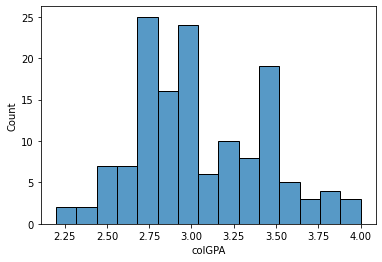

In [ ]:
sns.histplot(data=gpa, x='colGPA', bins=15)

In [ ]:
X = gpa.filter(['PC','hsGPA','ACT'])
y = gpa.pop('colGPA')

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=42)

In [ ]:
reg_tree = DecisionTreeRegressor(max_depth=4)
reg_tree.fit(X_train, y_train)

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=4,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')

In [ ]:
y_pred = reg_tree.predict(X_test)
y_fit_train = reg_tree.predict(X_train)

In [ ]:
def metricas(y_true, y_pred):
  print(f'MSE: {mean_squared_error(y_true, y_pred)}')
  print(f'MAE: {mean_absolute_error(y_true, y_pred)}')
  print(f'RMSE: {np.sqrt(mean_squared_error(y_true,y_pred))}')

In [ ]:
print('Métricas del entrenamiento',end='\n')
print('---'*10)
metricas(y_train, y_fit_train)
print('---'*10)
print('Métricas del testeo')
print('---'*10)
metricas(y_test, y_pred)

Métricas del entrenamiento
------------------------------
MSE: 0.08627729899187123
MAE: 0.23557414744824343
RMSE: 0.29372997632497644
------------------------------
Métricas del testeo
------------------------------
MSE: 0.1054165372866283
MAE: 0.23599054827893243
RMSE: 0.32467912973677304


[Text(193.55625, 195.696, 'X[1] <= 3.85\nmse = 0.138\nsamples = 112\nvalue = 3.043'),
 Text(136.01250000000002, 152.208, 'X[1] <= 3.15\nmse = 0.116\nsamples = 105\nvalue = 3.007'),
 Text(83.7, 108.72, 'X[0] <= 0.5\nmse = 0.13\nsamples = 27\nvalue = 2.833'),
 Text(41.85, 65.232, 'X[2] <= 23.5\nmse = 0.071\nsamples = 17\nvalue = 2.759'),
 Text(20.925, 21.744, 'mse = 0.031\nsamples = 11\nvalue = 2.636'),
 Text(62.775000000000006, 21.744, 'mse = 0.065\nsamples = 6\nvalue = 2.983'),
 Text(125.55000000000001, 65.232, 'X[1] <= 2.8\nmse = 0.204\nsamples = 10\nvalue = 2.96'),
 Text(104.625, 21.744, 'mse = 0.002\nsamples = 2\nvalue = 2.55'),
 Text(146.475, 21.744, 'mse = 0.202\nsamples = 8\nvalue = 3.062'),
 Text(188.32500000000002, 108.72, 'X[2] <= 17.5\nmse = 0.098\nsamples = 78\nvalue = 3.067'),
 Text(167.4, 65.232, 'mse = 0.0\nsamples = 1\nvalue = 3.5'),
 Text(209.25, 65.232, 'X[1] <= 3.65\nmse = 0.096\nsamples = 77\nvalue = 3.061'),
 Text(188.32500000000002, 21.744, 'mse = 0.102\nsamples = 

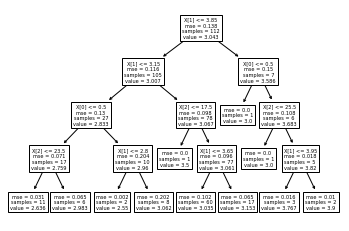

In [ ]:
from sklearn import tree

tree.plot_tree(reg_tree)

In [ ]:
wage1 = wd.data('wage1')

In [ ]:
X = wage1.filter(['female','educ','exper','tenure'])
y = wage1.pop('wage')

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
reg_tree2 = DecisionTreeRegressor(max_depth=3)
reg_tree2.fit(X_train, y_train)

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=3,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')

In [ ]:
y_pred = reg_tree2.predict(X_test)
y_pred_train = reg_tree2.predict(X_train)

In [ ]:
print('Métricas del entrenamiento',end='\n')
print('---'*10)
metricas(y_train, y_pred_train)
print('---'*10)
print('Métricas del testeo')
print('---'*10)
metricas(y_test, y_pred)

Métricas del entrenamiento
------------------------------
MSE: 8.189002058642126
MAE: 1.9846693877965496
RMSE: 2.8616432444737283
------------------------------
Métricas del testeo
------------------------------
MSE: 9.434193648199999
MAE: 2.1117408786822827
RMSE: 3.071513250533033


[Text(167.4, 190.26, 'X[1] <= 15.5\nmse = 13.533\nsamples = 420\nvalue = 5.859'),
 Text(83.7, 135.9, 'X[3] <= 2.5\nmse = 8.628\nsamples = 344\nvalue = 5.195'),
 Text(41.85, 81.53999999999999, 'X[0] <= 0.5\nmse = 3.86\nsamples = 177\nvalue = 4.171'),
 Text(20.925, 27.180000000000007, 'mse = 5.92\nsamples = 76\nvalue = 4.884'),
 Text(62.775000000000006, 27.180000000000007, 'mse = 1.64\nsamples = 101\nvalue = 3.635'),
 Text(125.55000000000001, 81.53999999999999, 'X[0] <= 0.5\nmse = 11.393\nsamples = 167\nvalue = 6.281'),
 Text(104.625, 27.180000000000007, 'mse = 14.679\nsamples = 93\nvalue = 7.175'),
 Text(146.475, 27.180000000000007, 'mse = 4.992\nsamples = 74\nvalue = 5.156'),
 Text(251.10000000000002, 135.9, 'X[3] <= 4.5\nmse = 24.708\nsamples = 76\nvalue = 8.864'),
 Text(209.25, 81.53999999999999, 'X[2] <= 9.5\nmse = 10.207\nsamples = 56\nvalue = 7.287'),
 Text(188.32500000000002, 27.180000000000007, 'mse = 5.181\nsamples = 39\nvalue = 6.452'),
 Text(230.175, 27.180000000000007, 'mse 

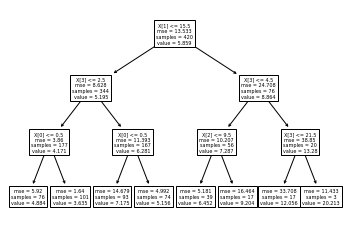

In [ ]:
tree.plot_tree(reg_tree2)

### Árboles de clasificación

El proceso es similar al de un árbol de regresión. Para el problema de regresión, la respuesta predicha para una observación es dada por la media de la respuesta de las observaciones de entrenamiento que pertenecen al mismo nodo. Para los árboles de decisión, se predice que cada observación pertenece a la clase más común en las observaciones de entrenamiento que pertenecen al nodo en cuestión.

La diferencia radica en que en este caso no se puede utilizar RSS como criterio para hacer los splits binarios. En su lugar pueden ser utilizados el índice Gini o la entropía:

$$G=\sum_{k=1}^K\hat{p}_{mk}(1-\hat{p}_{mk})$$

$$D=-\sum_{k=1}^K\hat{p}_{mk}\log \hat{p}_{mk}$$

Cuando se está construyendo un árbol de clasificación, cualquier de los dos es utilizado para evaluar la calidad de un split específico. Pueden ser utilizados para podar el árbol, pero si el ojetivo es la precisión de la predicción la tasa de error de clasificación puede ser mejor 

$$E=1-\max_k(\hat{p}_{mk})$$

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix
from sklearn.datasets import load_iris

In [ ]:
iris = load_iris()

In [ ]:
X = iris['data']
y = iris['target']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=42)

In [ ]:
clsr = DecisionTreeClassifier(max_depth=4)
clsr.fit(X_train, y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=4, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [ ]:
y_pred = clsr.predict(X_test)
y_fit_train = clsr.predict(X_train)

In [ ]:
def metricas_clas(y_true, y_pred):
  print(f'Accuracy: {accuracy_score(y_true, y_pred)}')
  print(f"Precision: {precision_score(y_true, y_pred, average='weighted')}")
  print(f"Recall: {recall_score(y_true, y_pred,average='weighted')}")

In [ ]:
print('---'*10)
print('Métricas en entrenamiento')
print('---'*10)
metricas_clas(y_train, y_fit_train)
print('---'*10)
print('Métricas en testeo')
print('---'*10)
metricas_clas(y_test, y_pred)

------------------------------
Métricas en entrenamiento
------------------------------
Accuracy: 0.975
Precision: 0.9767857142857144
Recall: 0.975
------------------------------
Métricas en testeo
------------------------------
Accuracy: 1.0
Precision: 1.0
Recall: 1.0


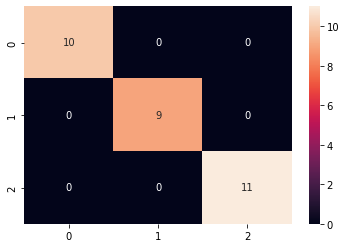

In [ ]:
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True)

[Text(106.52727272727273, 195.696, 'X[2] <= 2.45\ngini = 0.667\nsamples = 120\nvalue = [40, 41, 39]'),
 Text(76.0909090909091, 152.208, 'gini = 0.0\nsamples = 40\nvalue = [40, 0, 0]'),
 Text(136.96363636363637, 152.208, 'X[2] <= 4.75\ngini = 0.5\nsamples = 80\nvalue = [0, 41, 39]'),
 Text(60.872727272727275, 108.72, 'X[3] <= 1.65\ngini = 0.053\nsamples = 37\nvalue = [0, 36, 1]'),
 Text(30.436363636363637, 65.232, 'gini = 0.0\nsamples = 36\nvalue = [0, 36, 0]'),
 Text(91.30909090909091, 65.232, 'gini = 0.0\nsamples = 1\nvalue = [0, 0, 1]'),
 Text(213.05454545454546, 108.72, 'X[3] <= 1.75\ngini = 0.206\nsamples = 43\nvalue = [0, 5, 38]'),
 Text(152.1818181818182, 65.232, 'X[2] <= 4.95\ngini = 0.5\nsamples = 8\nvalue = [0, 4, 4]'),
 Text(121.74545454545455, 21.744, 'gini = 0.0\nsamples = 2\nvalue = [0, 2, 0]'),
 Text(182.61818181818182, 21.744, 'gini = 0.444\nsamples = 6\nvalue = [0, 2, 4]'),
 Text(273.92727272727274, 65.232, 'X[2] <= 4.85\ngini = 0.056\nsamples = 35\nvalue = [0, 1, 34]')

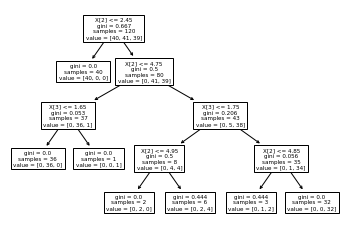

In [ ]:
tree.plot_tree(clsr)

### Ventajas y desventajas de los árboles de decisión

#### Ventajas

- Son fáciles de explicar a las personas. Son incluso más fáciles de explicar que la regresión lineal.
- Se cree que se parece más a la forma en que una persona toma decisiones que otros modelos.
- Los árboles pueden trabajar con variables cualitativas sin la necesidad de crear variables dummy. 
#### Desventajas

- No tienen usualmente la misma precisión de otros modelos de regresión y clasificación.

- Los árboles pueden ser poco robustos. Un pequeño cambio en los datos puede provocar un gran cambio en el árbol estimado final.

Todo esto se puede mejorar a través de random forests y metodologías de boosting.

## Random Forest

Una forma de reducir la varianza de un estimador es promediar juntos varios estimadores. Por ejemplo, se pueden entrenar $M$ árboles diferentes en diferentes subconjuntos de los datos, seleccionados aleatoriamente con remplazo, y así computar el ensable

$$f(\textbf{x})=\sum_{m=1}^M\frac{1}{M}f_m(\textbf{x})$$

donde $f_m$ es el árbol $m$-ésimo. Esto es conocido como bagging, que proviene de "bootstrap aggregating".

No obstante, las consecuencias de estos puede ser que se tengan variables predictoras altamente correlacionadas, lo cuál limita el monto de reducción de varianza posible.

La técnica de "Random forest" intenta evitar esta correlación creando árboles basados en selección aleatoria subconjunto de variables predictores, así como un subconjunto del total de los datos.

Como en el bagging, se construyen un número de árboles de decisión en muestras boostrap de entrenamiento. Pero cuando estos árboles de decisión se van construir, cada vez que se considera un split en el árbol, se toma una muestra aleatoria de $m$ variables predictoras del conjunto total de $p$ variables existentes.

La técnica de RF puede que no tome en cuenta la mayoría de las variables. ¿Por qué?

Suponga que hay una predictora fuerte, junto con predictoras moderadas. En el bagging, la mayoría o todos los árboles utilizarán la predictora fuerte, como consecuencia los árboles serán muy similares entre sí. RF fuerza que cada split considere solo un subconjunto de las predictoras. 

Si $m=p$ se tiene bagging, usualmente para RF se piensa en $m=\sqrt{p}$

In [ ]:
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.datasets import make_regression, make_classification

In [ ]:
X, y = make_classification(n_samples=1000,n_features=4)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=42)

In [ ]:
rf_cls = RandomForestClassifier(n_estimators=10)
rf_cls.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [ ]:
y_fit_train = rf_cls.predict(X_train)
y_pred = rf_cls.predict(X_test)

In [ ]:
print('---'*10)
print('Métricas en entrenamiento')
print('---'*10)
metricas_clas(y_train, y_fit_train)
print('---'*10)
print('Métricas en testeo')
print('---'*10)
metricas_clas(y_test, y_pred)

------------------------------
Métricas en entrenamiento
------------------------------
Accuracy: 0.995
Precision: 0.9950130052020808
Recall: 0.995
------------------------------
Métricas en testeo
------------------------------
Accuracy: 0.865
Precision: 0.8651177944862155
Recall: 0.865


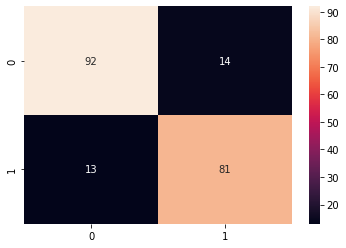

In [ ]:
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True)

In [ ]:
X, y = make_regression(n_samples=1000, n_features=4, noise=0.2)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=42)

In [ ]:
rf_reg = RandomForestRegressor(max_depth=4, n_estimators=20)
rf_reg.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=4, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=20, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [ ]:
y_fit_train = rf_reg.predict(X_train)
y_pred = rf_reg.predict(X_test)

In [ ]:
print('Métricas del entrenamiento',end='\n')
print('---'*10)
metricas(y_train, y_fit_train)
print('---'*10)
print('Métricas del testeo')
print('---'*10)
metricas(y_test, y_pred)

Métricas del entrenamiento
------------------------------
MSE: 2001.5758017794221
MAE: 34.844321591781004
RMSE: 44.73897408054215
------------------------------
Métricas del testeo
------------------------------
MSE: 2599.5026269032955
MAE: 40.36237930112169
RMSE: 50.98531775818697


In [ ]:
prof = [2,3,4,5]
n_est = [10,20,30,50,100]

for i in prof:
  for j in n_est:
    rf_reg = RandomForestRegressor(max_depth=i, n_estimators=j)
    rf_reg.fit(X_train, y_train)
    y_fit_train = rf_reg.predict(X_train)
    y_pred = rf_reg.predict(X_test)
    print(f'max_depth = {i}, n_estimators = {j}')
    print('---'*10)
    print('Métricas del entrenamiento',end='\n')
    print('---'*10)
    metricas(y_train, y_fit_train)
    print('---'*10)
    print('Métricas del testeo')
    print('---'*10)
    metricas(y_test, y_pred)


max_depth = 2, n_estimators = 10
------------------------------
Métricas del entrenamiento
------------------------------
MSE: 5734.82562142832
MAE: 59.37016363164548
RMSE: 75.72863145091372
------------------------------
Métricas del testeo
------------------------------
MSE: 6434.586591821818
MAE: 61.94134404302212
RMSE: 80.21587493646017
max_depth = 2, n_estimators = 20
------------------------------
Métricas del entrenamiento
------------------------------
MSE: 5744.625798296284
MAE: 59.49437184919455
RMSE: 75.79330971989734
------------------------------
Métricas del testeo
------------------------------
MSE: 6548.520387014764
MAE: 62.78338352203069
RMSE: 80.92292868535323
max_depth = 2, n_estimators = 30
------------------------------
Métricas del entrenamiento
------------------------------
MSE: 5530.274103493309
MAE: 58.44870920728802
RMSE: 74.36581273336094
------------------------------
Métricas del testeo
------------------------------
MSE: 6257.286004393155
MAE: 61.40647427

## Boosting

Existe otro método para mejorar la predicción de un árbol de decisión. Mientras el bagging consiste en crear multiples copias de los datos de entrenamiento utilizando bootstrap, ajustando un árbol de decisión por separado para cada uno, y después los comibna para crear un solo modelo predictivo, el boosting hace algo similar, excepto que los árboles crecen secuencialmente: cada árbol crece utilizando información de los árboles precedentes.

El boosting no utiliza boostrap, en lugar de eso cada árbol es ajustado en una versión modificada de los datos de entrenamiento.

In [ ]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.datasets import make_regression

In [ ]:
X, y = make_regression(n_samples=1000, n_features=5)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=42)

In [ ]:
tree_reg1 = DecisionTreeRegressor(max_depth=2)
tree_reg1.fit(X_train,y_train)

y_train2 = y_train - tree_reg1.predict(X_train)
tree_reg2 = DecisionTreeRegressor(max_depth=2)
tree_reg2.fit(X_train, y_train2)

y_train3 = y_train2 - tree_reg2.predict(X_train)
tree_reg3 = DecisionTreeRegressor(max_depth=2)
tree_reg3.fit(X_train, y_train3)

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=2,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')

Lo visto anteriormente se puede utilizar el módulo `GradientBoosting`  de sklearn. Puede utilizarse tanto para regresión como para clasificación.

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor

gbrt = GradientBoostingRegressor(max_depth=2, n_estimators=3, learning_rate=1)
gbrt.fit(X_train, y_train)

GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=1, loss='ls', max_depth=2,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=3,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=None, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

In [ ]:
y_fit_train = gbrt.predict(X_train)
y_pred = gbrt.predict(X_test)

In [ ]:
print('Métricas del entrenamiento',end='\n')
print('---'*10)
metricas(y_train, y_fit_train)
print('---'*10)
print('Métricas del testeo')
print('---'*10)
metricas(y_test, y_pred)

Métricas del entrenamiento
------------------------------
MSE: 4578.077528863841
MAE: 54.21405682569437
RMSE: 67.66149221576362
------------------------------
Métricas del testeo
------------------------------
MSE: 5319.234116580901
MAE: 56.925052164156895
RMSE: 72.93307971408379


## XGBoost


In [ ]:
import xgboost as xgb

In [ ]:
xg_reg = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=3)

In [ ]:
wage1 = wd.data('wage1')
X = wage1.filter(['female','educ','exper','tenure'])
y = wage1.pop('wage')

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=42)

In [ ]:
xg_reg.fit(X_train,y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=3,
             n_jobs=1, nthread=None, objective='reg:squarederror',
             random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             seed=None, silent=None, subsample=1, verbosity=1)

In [ ]:
y_fit_train = xg_reg.predict(X_train)
y_pred = xg_reg.predict(X_test)

In [ ]:
print('Métricas del entrenamiento',end='\n')
print('---'*10)
metricas(y_train, y_fit_train)
print('---'*10)
print('Métricas del testeo')
print('---'*10)
metricas(y_test, y_pred)

Métricas del entrenamiento
------------------------------
MSE: 26.662555126801383
MAE: 3.9500313145773753
RMSE: 5.163579681461436
------------------------------
Métricas del testeo
------------------------------
MSE: 27.490410669700978
MAE: 4.03102677385762
RMSE: 5.243129854361894
